In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import norm

from ipywidgets import interact, FloatSlider

In [2]:
def F_plus(x, type_ = 'R', E = 1.0, D = 1.0):
    if type_ == 'R':
        return x
    elif type_ == 'exp':
        return 1-np.exp(-x/E)
    elif type_ == 'N':
        return norm.cdf(x, loc = E, scale = D)
    
def F_minus(x, type_ = 'R', E = 1.0, D = 1.0):
    if type_ == 'R':
        return x
    elif type_ == 'exp':
        return 1-np.exp(-x/E)
    elif type_ == 'N':
        return norm.cdf(x, loc = E, scale = D)
    
def pi(l, p = 1./2):
    q = 1.0 - p
    if l == 1: 
        return p
    else:
        return q

In [3]:
def S(x, type_ = 'коэффициент Бхаттачарья'):
    """"Split function"""
    if type_ == 'коэффициент Бхаттачарья':
        x = x*(1-x)
        return np.sqrt(x)
    elif type_ == 'gini':
        return 1 - (x**2 + (1-x)**2)
    elif type_ == 'entropy':
        return -(x*np.log2(x) + (1-x)*np.log2(1-x))/2

C:\Users\Николай\AppData\Local\Temp\ipykernel_3584\2078300938.py:9: RuntimeWarning: divide by zero encountered in log2
  return -(x*np.log2(x) + (1-x)*np.log2(1-x))/2
C:\Users\Николай\AppData\Local\Temp\ipykernel_3584\2078300938.py:9: RuntimeWarning: invalid value encountered in multiply
  return -(x*np.log2(x) + (1-x)*np.log2(1-x))/2


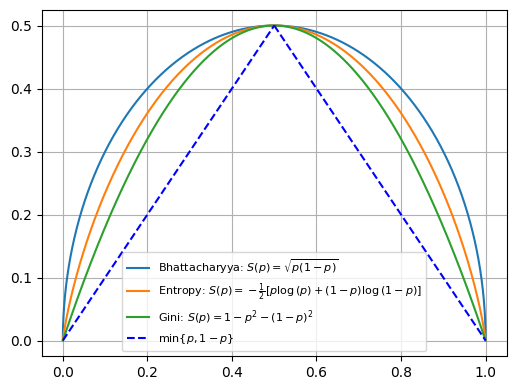

In [13]:
eps = 1e-6
x =np.array([i for i in range(10001)])/10000.0
x[0] = eps
plt.figure(figsize = (8*0.75, 6*0.75))
plt.plot(x, S(x), label = 'Bhattacharyya: $S(p) = \sqrt{p(1-p)}$')
plt.plot(x, S(x, type_ = 'entropy'), label = r'Entropy: $S(p) = -\frac{1}{2}[p\log{(p)} + (1-p)\log{(1-p)}]$')
plt.plot(x, S(x, type_ = 'gini'), label = 'Gini: $S(p) = 1 - p^2 - (1-p)^2$')
plt.plot(x[:len(x)//2], x[:len(x)//2], c = 'b', linestyle = '--')
plt.plot(x[len(x)//2:], 1-x[len(x)//2:], c= 'b', linestyle = '--', label = '$\min\{p, 1- p\}$')
#plt.scatter(x, S(x), s = 0.2, c = 'r')
plt.legend(fontsize = 8)
plt.grid()
plt.savefig('img1.png')
plt.show()

In [4]:
def H(x, type_plus, E_plus, D_plus, type_minus, E_minus, D_minus, p_l):
    F_plus_values = F_plus(x, type_ = type_plus, E = E_plus, D = D_plus)
    F_minus_values = F_minus(x, type_ = type_minus, E = E_minus, D = D_minus)
    
    pi_plus, pi_minus = pi(l = 1, p = p_l), pi(l = -1, p = p_l)
    
    P_X_less = F_minus_values*pi_minus + F_plus_values*pi_plus
    P_X_more = 1. - P_X_less
    q_less = F_plus_values*pi_plus/P_X_less
    q_more = (1. - F_plus_values)*pi_plus/P_X_more
    return S(q_less)*P_X_less + S(q_more)*P_X_more

def H_n(t, values_plus, values_minus):
    
    pi_plus_n = len(values_plus)/(len(values_plus) + len(values_minus))
    pi_minus_n = 1 - pi_plus_n
    
    Count_X_less_t_plus = np.searchsorted(values_plus, t, side='right')
    Count_X_more_t_plus = len(values_plus) - Count_X_less_t_plus
    
    Count_X_less_t = Count_X_less_t_plus + np.searchsorted(values_minus, t, side='right')
    Count_X_more_t = len(values_plus) + len(values_minus) - Count_X_less_t
    
    q_less_n = Count_X_less_t_plus/Count_X_less_t
    q_more_n = Count_X_more_t_plus/Count_X_more_t
    
    P_X_less_n = Count_X_less_t/(len(values_plus) + len(values_minus))
    P_X_more_n = 1.0 - P_X_less_n
    
    return S(q_less_n)*P_X_less_n + S(q_more_n)*P_X_more_n

In [5]:
#Поиск аргминимума функции
def Argmin_H(args, H, bounds):
    #args = (param1, param2, ...)  # Замените param1, param2, ... на ваши параметры
    # Начальное приближение для оптимизации
    initial_guess = (bounds[0][0] + bounds[0][1])/2
    #initial_guess = bounds[0][1]
    # Поиск минимума функции H(x)
    result = minimize(H, initial_guess, args=args, method='Nelder-Mead', bounds = bounds)

    # Вывод результата
    if result.success:
        print("Минимум функции найден успешно!")
        print("Аргминимум:", result.x)
        print("Значение функции в аргминимуме:", result.fun)
        return result
    else:
        print("Не удалось найти минимум функции.")

In [6]:
def A_f(F_plus_T, F_minus_T, pi_plus, pi_minus):
    I1 = pi_plus*pi_minus*F_minus_T/(2*np.sqrt(pi_plus*pi_minus*F_plus_T*F_minus_T))
    I2 = pi_plus*pi_minus*(1-F_minus_T)/(2*np.sqrt(pi_plus*pi_minus*(1-F_plus_T)*(1-F_minus_T)))
    return I1 - I2

def B_f(F_plus_T, F_minus_T, pi_plus, pi_minus):
    I1 = pi_plus*pi_minus*F_plus_T/(2*np.sqrt(pi_plus*pi_minus*F_plus_T*F_minus_T))
    I2 = pi_plus*pi_minus*(1-F_plus_T)/(2*np.sqrt(pi_plus*pi_minus*(1-F_plus_T)*(1-F_minus_T)))
    return I1 - I2

In [7]:
def H_linear(x, type_plus, E_plus, D_plus, type_minus, E_minus, D_minus, p_l, A, B):
    F_plus_values = F_plus(x, type_ = type_plus, E = E_plus, D = D_plus)
    F_minus_values = F_minus(x, type_ = type_minus, E = E_minus, D = D_minus)
    
    pi_plus, pi_minus = pi(l = 1, p = p_l), pi(l = -1, p = p_l)
    
    return F_plus_values*A + F_minus_values*B

def H_n_linear(t, values_plus, values_minus, A, B):
    
    pi_plus_n = len(values_plus)/(len(values_plus) + len(values_minus))
    pi_minus_n = 1 - pi_plus_n
    
    Count_X_less_t_plus = np.searchsorted(values_plus, t, side='right')
    Count_X_less_t_minus = np.searchsorted(values_minus, t, side='right')

    return A*Count_X_less_t_plus/len(values_plus) + B*Count_X_less_t_minus/len(values_minus)

In [8]:
def pl(setka, All_diffs, c = 0.75, save = False, Name_png = "1.png", label = r"$|T-T_n|$"):
    plt.figure(figsize = (10*c, 8*c))
    plt.plot(setka, np.array(setka)**(-1./3), '-', color = 'blue', label = r"$n^{-\frac{1}{3}}$",lw = 0.5)
    plt.plot(setka, np.array(setka)**(-1./2), '-', color = 'r', label = r"$n^{-\frac{1}{2}}$",lw = 0.5)
    plt.plot(setka, np.array(setka)**(-1./4), '-', color = 'black', label = r"$n^{-\frac{1}{4}}$",lw = 0.5)
    plt.plot(setka, All_diffs, 'go-', color = 'g', label = label, lw = 0.8, markersize = 5)
    #plt.plot(setka, All_diffs*(np.array(setka)**(1./3)), '-', color = 'g', label = "$|T-T_n|$", lw = 0.5)
    plt.legend(fontsize = 25)
    plt.grid()
    if save is True:
        plt.savefig(Name_png)
    plt.show()

Минимум функции найден успешно!
Аргминимум: [2.19720459]
Значение функции в аргминимуме: 0.48112522432558913


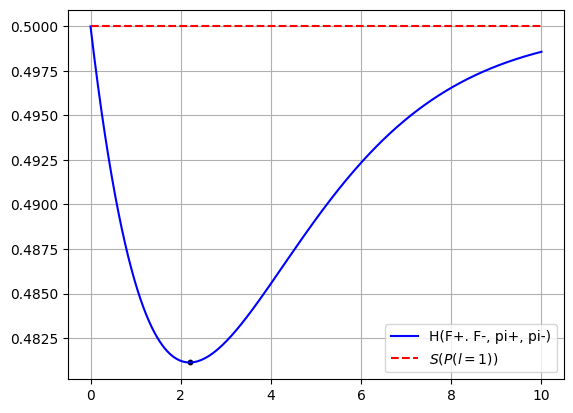

In [9]:
eps = 1e-9
x = np.linspace(0, 10, 100000)
x[0] = eps
p_l = 0.5
args = ('exp', 1.0, None, 'exp', 2.0, None, p_l)

plt.plot(x, H(x, type_plus=args[0], E_plus = args[1], D_plus = args[2], 
              type_minus = args[3], E_minus = args[4], D_minus = args[5], 
              p_l = args[6]), 
         c = 'b', label = "H(F+. F-, pi+, pi-)")
plt.hlines(y = S(p_l), xmin = min(x), xmax = max(x), linestyles='--', color = 'r', label = '$S(P(l=1))$')
plt.legend()
plt.grid()


bounds = [(min(x), max(x))]
result = Argmin_H(args, H, bounds)

plt.scatter(result.x, result.fun, color = 'black', s = 10)
plt.show()
exp_T = result.x

C:\Users\Николай\AppData\Local\Temp\ipykernel_3584\2284826204.py:10: RuntimeWarning: invalid value encountered in divide
  q_more = (1. - F_plus_values)*pi_plus/P_X_more


Минимум функции найден успешно!
Аргминимум: [1.93037109]
Значение функции в аргминимуме: 0.452834553627717


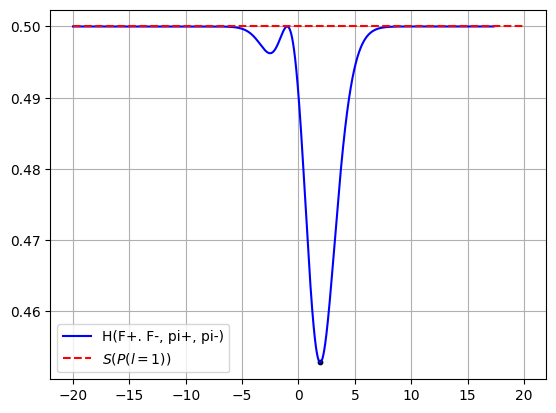

In [10]:
x = np.linspace(-20, 20, 10000)
p_l = 0.5
args = ('N', 0.0, 1.0, 'N', 1, 2.0, p_l)

plt.plot(x, H(x, type_plus=args[0], E_plus=args[1], D_plus=args[2],
              type_minus=args[3], E_minus=args[4], D_minus=args[5],
              p_l=args[6]),
         c='b', label="H(F+. F-, pi+, pi-)")
plt.hlines(y=S(p_l), xmin=min(x), xmax=max(x), linestyles='--', color='r', label='$S(P(l=1))$')
plt.legend()
plt.grid()

bounds = [(1, 7)]
result = Argmin_H(args, H, bounds)

plt.scatter(result.x, result.fun, color='black', s=10)
plt.show()
N_T = result.x

In [11]:
print(N_T, exp_T)

[1.93037109] [2.19720459]


# Эмпирические функционалы:

In [27]:
%%time
np.random.seed(42)
#Соберем сэмпл эмпирический
n = 500
p_l = 0.5
type_ = "N"
args = ('N', 0.0, 1., 'N', 1, 2.0, p_l)
#type_ = "exp"
#args = ('exp', 1.0, None, 'exp', 2.0, None, p_l)
values_plus = []
values_minus = []
for i in range(n):
    p = np.random.rand()
    if type_ == 'N':
        if p<=p_l:
            values_plus.append(np.random.normal(loc = args[1], scale = args[2]))
        else:
            values_minus.append(np.random.normal(loc = args[4], scale = args[5]))
    elif type_ == 'exp':
        if p<=p_l:
            values_plus.append(np.random.exponential(scale = args[1]))
        else:
            values_minus.append(np.random.exponential(scale = args[4]))

values_plus = np.sort(values_plus)
values_minus = np.sort(values_minus)
eps = 1e-9
t = np.sort(np.hstack((values_plus, values_minus)))


H_n_values = H_n(t, values_plus, values_minus)
H_true = H(t, type_plus=args[0], E_plus=args[1], D_plus=args[2],
           type_minus=args[3], E_minus=args[4], D_minus=args[5], 
           p_l=args[6])

CPU times: total: 0 ns
Wall time: 3.99 ms


C:\Users\Николай\AppData\Local\Temp\ipykernel_3584\2284826204.py:25: RuntimeWarning: invalid value encountered in divide
  q_more_n = Count_X_more_t_plus/Count_X_more_t


Минимум функции найден успешно!
Аргминимум: [1.93037109]
Значение функции в аргминимуме: 0.452834553627717


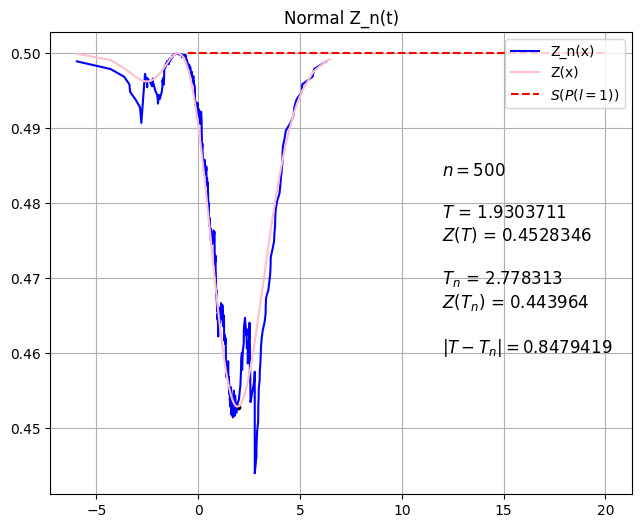

In [28]:
result = Argmin_H(args, H, bounds)
c = 0.75
plt.figure(figsize = (10*c, 8*c))
plt.plot(t, H_n_values, label = 'Z_n(x)', color = 'blue')
plt.plot(t, H_true, label = 'Z(x)', color = 'pink')
plt.hlines(y=S(p_l), xmin=-0.5, xmax=20, linestyles='--', color='r', label='$S(P(l=1))$')
plt.legend()
plt.grid()

plt.scatter(result.x, result.fun, color='black', s=10)

nan_indices = np.isnan(H_n_values)
i_min = np.argmin(H_n_values[~nan_indices])
T_n = t[i_min]

text = f"$n = {n}$\n\n$T$ = {round(result.x[0], 7)}\n$Z(T)$ = {round(result.fun, 7)}\n\n\
$T_n$ = {round(T_n, 7)}\n$Z(T_n)$ = {round(H_n_values[i_min], 7)}\n\n$|T-T_n| = {abs(round(result.x[0]-T_n,7))}$"
if type_ == 'exp':
    plt.text(17, 0.485, text, fontsize = 12)
elif type_ == 'N':
    plt.text(12, 0.46, text, fontsize = 12)
#plt.savefig("N100.png")
plt.title("Normal Z_n(t)")
plt.show()

In [34]:
T = result.x
F_plus_T = F_plus(T, type_ = args[0], E = args[1], D = args[2])
F_minus_T = F_minus(T, type_ = args[3], E = args[4], D = args[5])

A = A_f(F_plus_T,F_minus_T,
        pi_plus=args[6], pi_minus = 1 - args[6]
       )
B = B_f(F_plus_T,F_minus_T,
        pi_plus=args[6], pi_minus = 1 - args[6]
       )
(A, B)

(array([-0.65656312]), array([0.22705928]))

Минимум функции найден успешно!
Аргминимум: [1.93037109]
Значение функции в аргминимуме: -0.48478395427703974


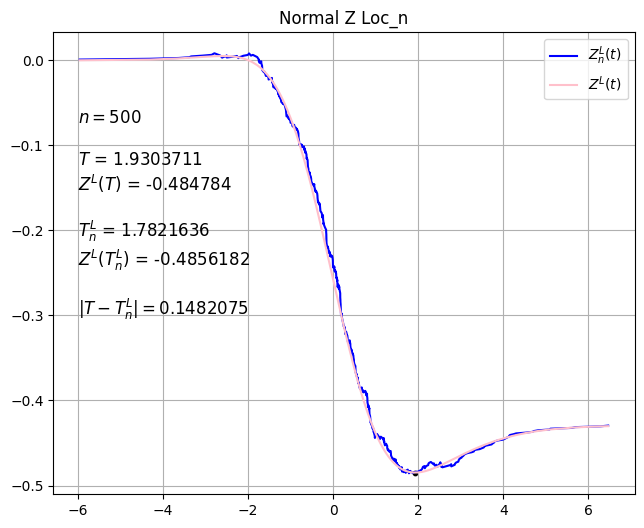

In [44]:
args = ('N', 0.0, 1., 'N', 1, 2.0, p_l, A, B)
result = Argmin_H(args, H_linear, bounds)
c = 0.75

H_n_linear_values = H_n_linear(t, values_plus, values_minus, A, B)

plt.figure(figsize = (10*c, 8*c))
plt.plot(t, H_n_linear_values, label = '$Z_n^{L}(t)$', color = 'blue')
plt.plot(t, H_linear(t, type_plus=args[0], E_plus=args[1], D_plus=args[2],
              type_minus=args[3], E_minus=args[4], D_minus=args[5],
              p_l=args[6], A = A, B = B), label = '$Z^{L}(t)$', color = 'pink')
#plt.hlines(y=S(p_l), xmin=-0.5, xmax=20, linestyles='--', color='r', label='$S(P(l=1))$')
plt.legend()
plt.grid()

plt.scatter(result.x, result.fun, color='black', s=10)

nan_indices = np.isnan(H_n_linear_values)
i_min = np.argmin(H_n_linear_values[~nan_indices])
T_n_linear = t[i_min]

text = f"$n = {n}$\n\n$T$ = {round(result.x[0], 7)}\n$Z^L(T)$ = {round(result.fun, 7)}\n\n\
$T_n^L$ = {round(T_n_linear, 7)}\n$Z^L(T_n^L)$ = {round(H_n_linear_values[i_min], 7)}\n\n$|T-T_n^L| = {abs(round(result.x[0]-T_n_linear,7))}$"
plt.text(-6, -0.3, text, fontsize = 12)
plt.title("Normal Z Loc_n")
#plt.savefig("N_linear_1000000.png")
plt.show()

In [51]:
#Соберем выборку для отрисовок:

In [45]:
%%time
np.random.seed(42)
#Соберем сэмпл эмпирический
n = 500
p_l = 0.5
#type_ = "N"
#args = ('N', 0.0, 1., 'N', 1, 2.0, p_l)
type_ = "exp"
args = ('exp', 1.0, None, 'exp', 2.0, None, p_l)
values_plus = []
values_minus = []
for i in range(n):
    p = np.random.rand()
    if type_ == 'N':
        if p<=p_l:
            values_plus.append(np.random.normal(loc = args[1], scale = args[2]))
        else:
            values_minus.append(np.random.normal(loc = args[4], scale = args[5]))
    elif type_ == 'exp':
        if p<=p_l:
            values_plus.append(np.random.exponential(scale = args[1]))
        else:
            values_minus.append(np.random.exponential(scale = args[4]))

values_plus = np.sort(values_plus)
values_minus = np.sort(values_minus)
eps = 1e-9
t = np.sort(np.hstack((values_plus, values_minus)))


H_n_values = H_n(t, values_plus, values_minus)
H_true = H(t, type_plus=args[0], E_plus=args[1], D_plus=args[2],
           type_minus=args[3], E_minus=args[4], D_minus=args[5], 
           p_l=args[6])

CPU times: total: 0 ns
Wall time: 1.99 ms


C:\Users\Николай\AppData\Local\Temp\ipykernel_3584\2284826204.py:25: RuntimeWarning: invalid value encountered in divide
  q_more_n = Count_X_more_t_plus/Count_X_more_t


Минимум функции найден успешно!
Аргминимум: [2.19726562]
Значение функции в аргминимуме: 0.48112522432848803


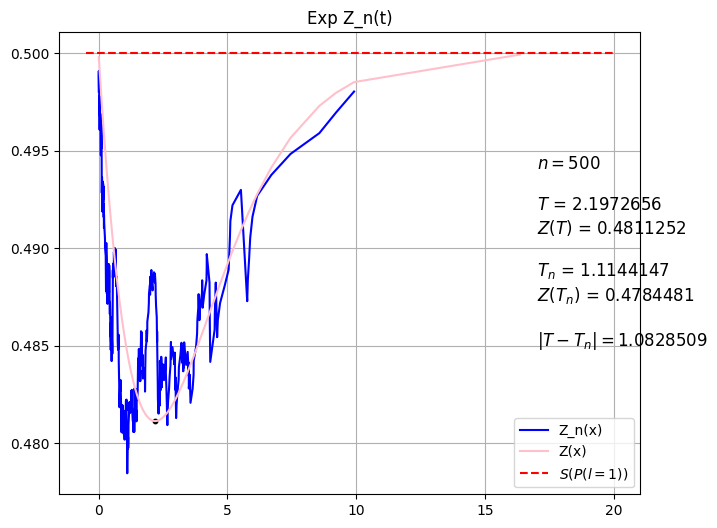

In [46]:
result = Argmin_H(args, H, bounds)
c = 0.75
plt.figure(figsize = (10*c, 8*c))
plt.plot(t, H_n_values, label = 'Z_n(x)', color = 'blue')
plt.plot(t, H_true, label = 'Z(x)', color = 'pink')
plt.hlines(y=S(p_l), xmin=-0.5, xmax=20, linestyles='--', color='r', label='$S(P(l=1))$')
plt.legend()
plt.grid()

plt.scatter(result.x, result.fun, color='black', s=10)

nan_indices = np.isnan(H_n_values)
i_min = np.argmin(H_n_values[~nan_indices])
T_n = t[i_min]

text = f"$n = {n}$\n\n$T$ = {round(result.x[0], 7)}\n$Z(T)$ = {round(result.fun, 7)}\n\n\
$T_n$ = {round(T_n, 7)}\n$Z(T_n)$ = {round(H_n_values[i_min], 7)}\n\n$|T-T_n| = {abs(round(result.x[0]-T_n,7))}$"
if type_ == 'exp':
    plt.text(17, 0.485, text, fontsize = 12)
elif type_ == 'N':
    plt.text(12, 0.46, text, fontsize = 12)
plt.savefig("N100.png")
plt.title("Exp Z_n(t)")
plt.show()

In [47]:
T = result.x
F_plus_T = F_plus(T, type_ = args[0], E = args[1], D = args[2])
F_minus_T = F_minus(T, type_ = args[3], E = args[4], D = args[5])

A = A_f(F_plus_T,F_minus_T,
        pi_plus=args[6], pi_minus = 1 - args[6]
       )
B = B_f(F_plus_T,F_minus_T,
        pi_plus=args[6], pi_minus = 1 - args[6]
       )
(A, B)

(array([-0.21651024]), array([0.14433831]))

Минимум функции найден успешно!
Аргминимум: [2.19726562]
Значение функции в аргминимуме: -0.09622800725150389


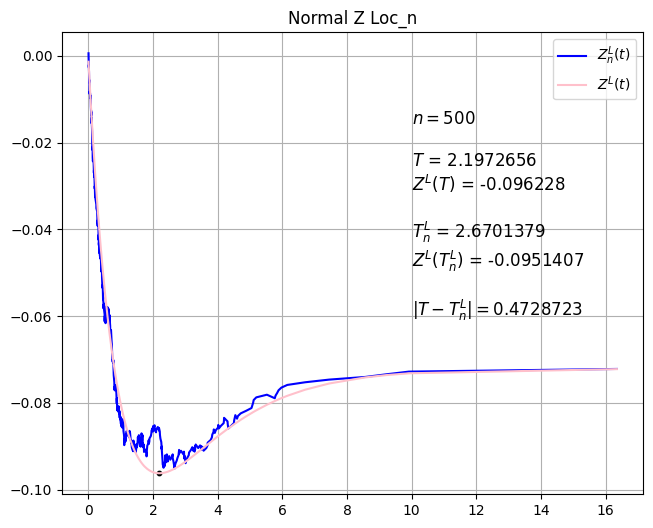

In [50]:
args = ('exp', 1.0, None, 'exp', 2.0, None, p_l, A, B)
result = Argmin_H(args, H_linear, bounds)
c = 0.75

H_n_linear_values = H_n_linear(t, values_plus, values_minus, A, B)

plt.figure(figsize = (10*c, 8*c))
plt.plot(t, H_n_linear_values, label = '$Z_n^{L}(t)$', color = 'blue')
plt.plot(t, H_linear(t, type_plus=args[0], E_plus=args[1], D_plus=args[2],
              type_minus=args[3], E_minus=args[4], D_minus=args[5],
              p_l=args[6], A = A, B = B), label = '$Z^{L}(t)$', color = 'pink')
#plt.hlines(y=S(p_l), xmin=-0.5, xmax=20, linestyles='--', color='r', label='$S(P(l=1))$')
plt.legend()
plt.grid()

plt.scatter(result.x, result.fun, color='black', s=10)

nan_indices = np.isnan(H_n_linear_values)
i_min = np.argmin(H_n_linear_values[~nan_indices])
T_n_linear = t[i_min]

text = f"$n = {n}$\n\n$T$ = {round(result.x[0], 7)}\n$Z^L(T)$ = {round(result.fun, 7)}\n\n\
$T_n^L$ = {round(T_n_linear, 7)}\n$Z^L(T_n^L)$ = {round(H_n_linear_values[i_min], 7)}\n\n$|T-T_n^L| = {abs(round(result.x[0]-T_n_linear,7))}$"
plt.text(10, -0.06, text, fontsize = 12)
plt.title("Normal Z Loc_n")
#plt.savefig("N_linear_1000000.png")
plt.show()

## <center> Функция поиска $T_n$, $T_n^{Loc}$

In [16]:
def Search_T_n_T_n_linear(n, T_n_values, T_n_linear_values, simulations = 1, type_ = 'N'):
    
    p_l = 0.5
    if type_ == "N":
        args = ('N', 0.0, 1., 'N', 1, 2.0, p_l)
        T = N_T[0]
    elif type_ == "exp":
        args = ('exp', 1.0, None, 'exp', 2.0, None, p_l)
        T = exp_T[0]
    
    F_plus_T = F_plus(T, type_ = args[0], E = args[1], D = args[2])
    F_minus_T = F_minus(T, type_ = args[3], E = args[4], D = args[5])

    A = A_f(F_plus_T,F_minus_T,
            pi_plus=args[6], pi_minus = 1 - args[6]
           )
    B = B_f(F_plus_T,F_minus_T,
            pi_plus=args[6], pi_minus = 1 - args[6]
           )
    
    T_n_values_n = []
    T_n_linear_values_n = []
    
    
    for simulation in range(simulations):
        if simulations!=1:
            np.random.seed(simulation)
        else:
            np.random.seed(42)
        values_plus = []
        values_minus = []
        for i in range(n):
            p = np.random.rand()
            if type_ == "N":
                if p<=p_l:
                    values_plus.append(np.random.normal(loc = args[1], scale = args[2]))
                else:
                    values_minus.append(np.random.normal(loc = args[4], scale = args[5]))
            elif type_ == 'exp':
                if p<=p_l:
                    values_plus.append(np.random.exponential(scale = args[1]))
                else:
                    values_minus.append(np.random.exponential(scale = args[4]))

        values_plus = np.sort(values_plus)
        values_minus = np.sort(values_minus)
        
        t = np.sort(np.hstack((values_plus, values_minus)))
        H_n_linear_values = H_n_linear(t, values_plus, values_minus, A, B)
        nan_indices = np.isnan(H_n_linear_values)
        T_n_linear = t[np.argmin(H_n_linear_values[~nan_indices])]
        
        
        H_n_values = H_n(t, values_plus, values_minus)
        nan_indices = np.isnan(H_n_values)
        T_n = t[np.argmin(H_n_values[~nan_indices])]
        
        T_n_values_n.append(T_n)
        T_n_linear_values_n.append(T_n_linear)
    
    #T_n_values.append(np.mean(T_n_values_n))
    #T_n_linear_values.append(np.mean(T_n_linear_values_n))
    return np.mean(T_n_values_n), np.mean(T_n_linear_values_n)

In [17]:
from tqdm import tqdm

# <center> Normal distribution:

In [37]:
%%time
T_n_values = []
T_n_linear_values = []

setka1 = [1000, 5000, 10000, 20000, 30000, 40000, 50000, 80000]
setka2 = [100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000]
setka3 = [1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 10000000]
setka4 = [12000000, 14000000, 16000000, 18000000, 20000000, 25000000]
setka5 = [30000000, 40000000, 50000000, 60000000, 70000000, 80000000, 90000000, 100000000, 110000000, 120000000]
setka6 = [130000000, 140000000, 150000000, 160000000, 170000000, 180000000, 190000000, 200000000, 210000000, 220000000]
setka = setka1 + setka2 + setka3 + setka4 + setka5 + setka6

for nn in tqdm(setka):
    T_n, T_n_linear = Search_T_n_T_n_linear(nn, T_n_values, T_n_linear_values, simulations=1, type_ = 'N')
    T_n_values.append(T_n)
    T_n_linear_values.append(T_n_linear)

  0%|                                                                                           | 0/53 [00:00<?, ?it/s]C:\Users\21352410\AppData\Local\Temp/ipykernel_15084/2284826204.py:25: RuntimeWarning: invalid value encountered in true_divide
  q_more_n = Count_X_more_t_plus/Count_X_more_t
100%|███████████████████████████████████████████████████████████████████████████████| 53/53 [4:00:34<00:00, 272.35s/it]

Wall time: 4h 34s


C:\Users\21352410\AppData\Local\Temp/ipykernel_15084/3585281444.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(setka, All_diffs, 'go-', color = 'g', label = label, lw = 0.8, markersize = 5)


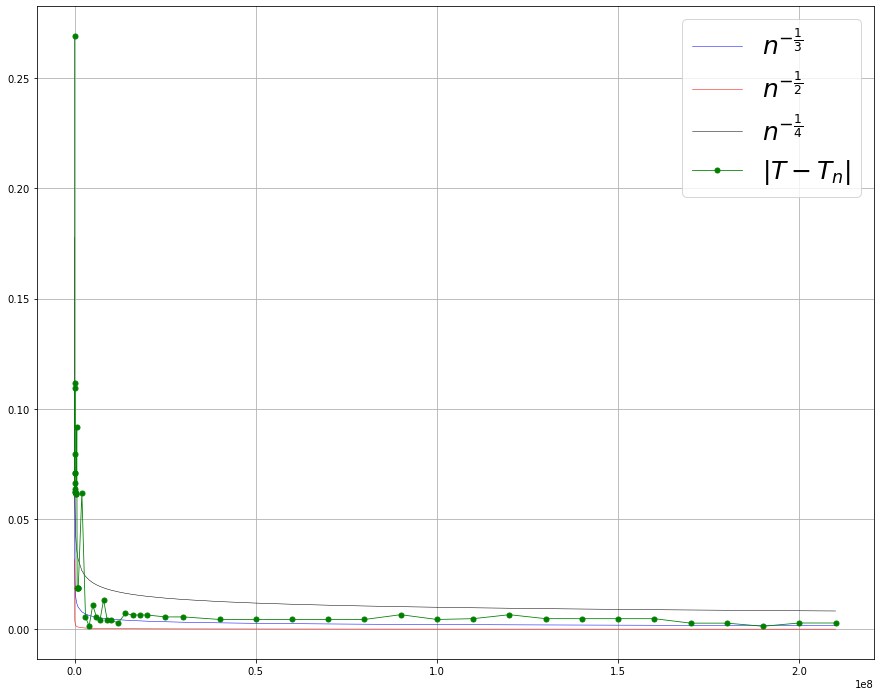

In [51]:
pl(setka, abs(T_n_values - N_T), c = 1.5, save = True, Name_png = "T-T_n.png", label = r"$|T-T_n|$")

C:\Users\21352410\AppData\Local\Temp/ipykernel_15084/3585281444.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(setka, All_diffs, 'go-', color = 'g', label = label, lw = 0.8, markersize = 5)


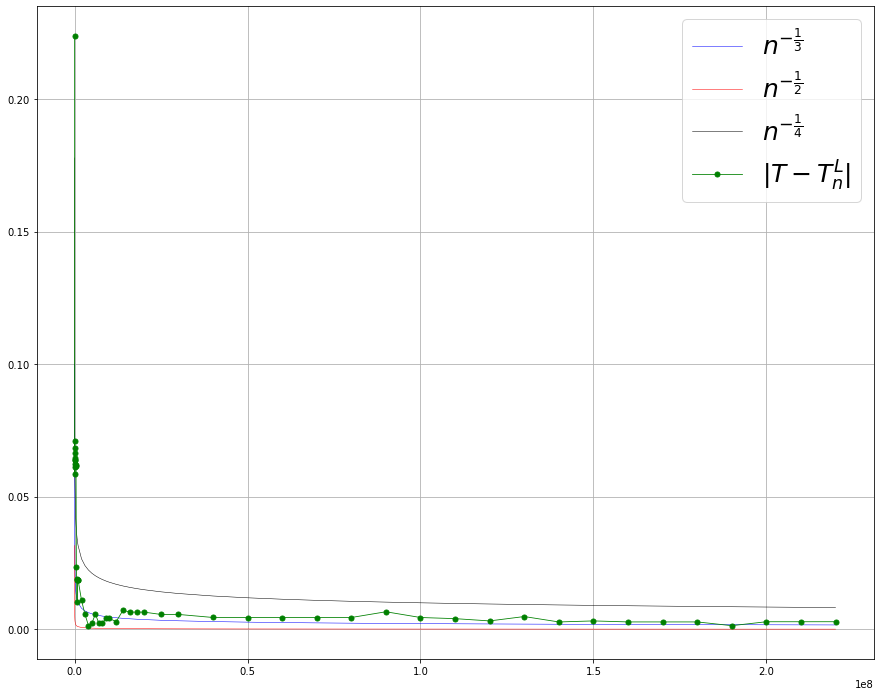

In [53]:
pl(setka, abs(T_n_linear_values - N_T), c = 1.5, save = True, Name_png="T-T_n_loc.png", label = r"$|T-T_n^L|$")

C:\Users\21352410\AppData\Local\Temp/ipykernel_15084/3585281444.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(setka, All_diffs, 'go-', color = 'g', label = label, lw = 0.8, markersize = 5)


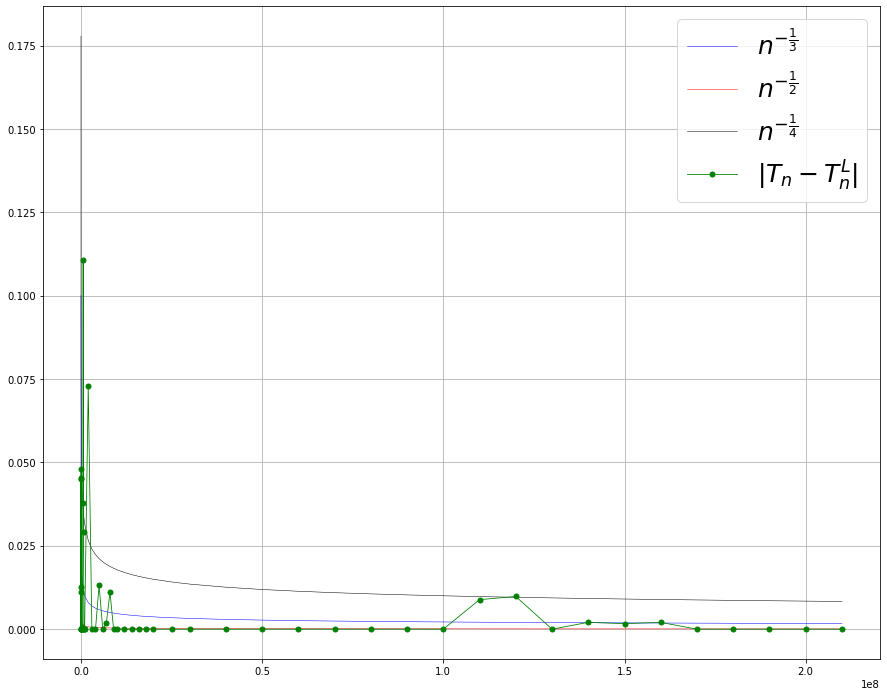

In [57]:
pl(setka, abs(np.array(T_n_values) - np.array(T_n_linear_values)), save = True, 
   Name_png = "T_n-T_n_loc.png", 
   c = 1.5, label = r"$|T_n-T_n^L|$")

# <center> Exponential distribution:

In [83]:
%%time
T_n_values[:] = []
T_n_linear_values[:] = []

setka1 = [1000, 5000, 10000, 20000, 30000, 40000, 50000, 80000]
setka2 = [100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000]
setka3 = [1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 10000000]
setka4 = [12000000, 14000000, 16000000, 18000000, 20000000, 25000000]
setka5 = [30000000, 40000000, 50000000, 60000000, 70000000, 80000000, 90000000, 100000000, 110000000, 120000000]
setka6 = [130000000, 140000000, 150000000, 160000000, 170000000, 180000000, 190000000, 200000000, 210000000, 220000000]
#setka = setka1
setka = setka1 + setka2 + setka3 + setka4 + setka5 + setka6

for nn in tqdm(setka):
    T_n, T_n_linear = Search_T_n_T_n_linear(nn, T_n_values, T_n_linear_values, simulations=1, type_ = 'exp')
    T_n_values.append(T_n)
    T_n_linear_values.append(T_n_linear)

  0%|                                                                                           | 0/53 [00:00<?, ?it/s]C:\Users\21352410\AppData\Local\Temp/ipykernel_15084/2284826204.py:25: RuntimeWarning: invalid value encountered in true_divide
  q_more_n = Count_X_more_t_plus/Count_X_more_t
100%|███████████████████████████████████████████████████████████████████████████████| 53/53 [5:56:55<00:00, 404.06s/it]

Wall time: 5h 56min 55s


C:\Users\21352410\AppData\Local\Temp/ipykernel_15084/3585281444.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(setka, All_diffs, 'go-', color = 'g', label = label, lw = 0.8, markersize = 5)


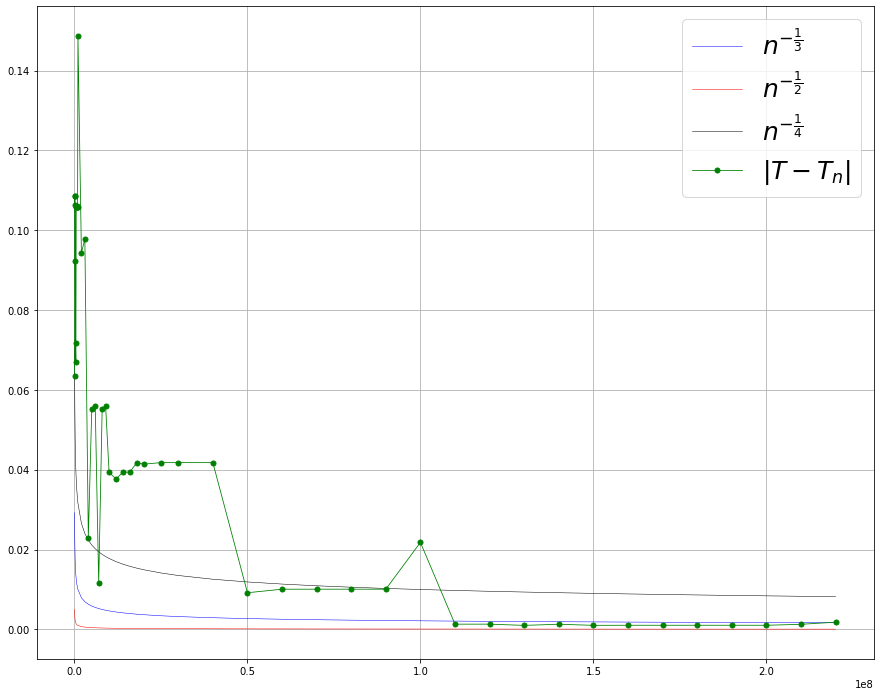

In [135]:
pl(setka[5:], abs(T_n_values[5:] - exp_T), c = 1.5, save = True, Name_png = "exp_T-T_n.png", label = r"$|T-T_n|$")

C:\Users\21352410\AppData\Local\Temp/ipykernel_15084/3585281444.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(setka, All_diffs, 'go-', color = 'g', label = label, lw = 0.8, markersize = 5)


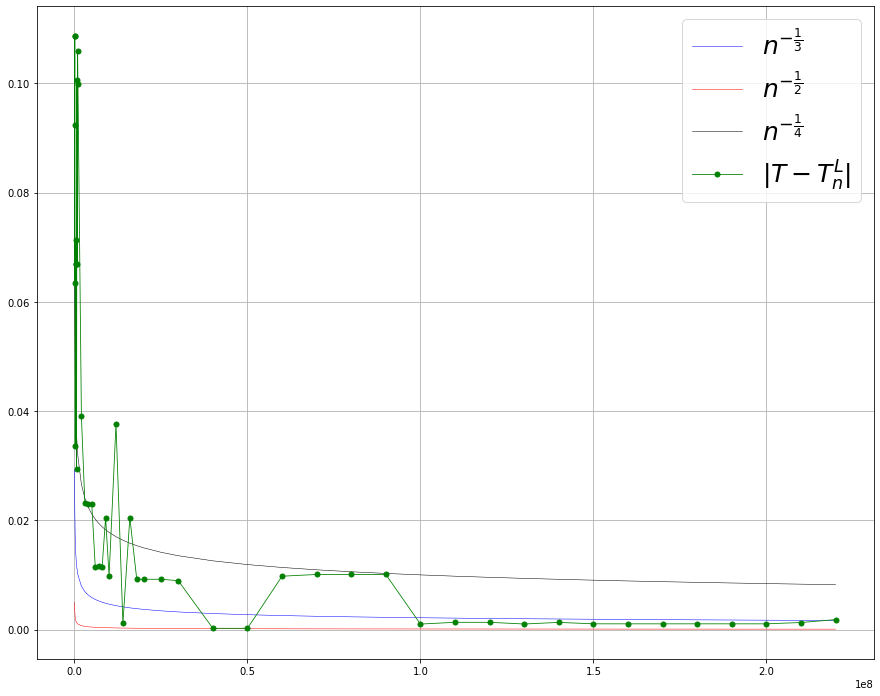

In [141]:
pl(setka[5:], abs(T_n_linear_values - exp_T)[5:], c = 1.5, save = True, Name_png="exp_T-T_n_loc.png", 
   label = r"$|T-T_n^L|$")

C:\Users\21352410\AppData\Local\Temp/ipykernel_15084/3585281444.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(setka, All_diffs, 'go-', color = 'g', label = label, lw = 0.8, markersize = 5)


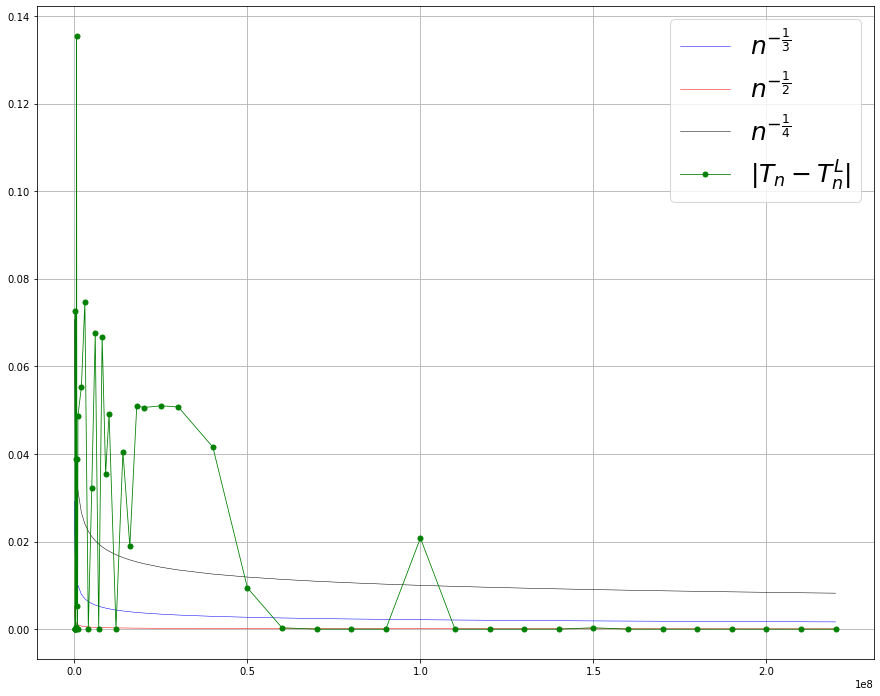

In [143]:
pl(setka[5:], abs(np.array(T_n_values) - np.array(T_n_linear_values))[5:], save = True, 
   Name_png = "exp_T_n-T_n_loc.png", 
   c = 1.5, label = r"$|T_n-T_n^L|$")